In [1]:
import torch, os

In [2]:
path = os.path.expanduser("~/Downloads/")
os.listdir(path)
split_num = 1
pth = path + "roberta_base_lora_mnli.bin"
pth

'/Users/markuszhang/Downloads/roberta_base_lora_mnli.bin'

In [3]:
# Assume: M1 Mac chip with MPS GPU
# Load as memmap in cpu -> move to MPS GPU in float32 -> visualise in cpu
state_dict = torch.load(pth, map_location=torch.device("cpu"), mmap=True)
{key: state_dict[key].shape for key in state_dict.keys()}

{'roberta.encoder.layer.0.attention.self.query.lora_A': torch.Size([8, 768]),
 'roberta.encoder.layer.0.attention.self.query.lora_B': torch.Size([768, 8]),
 'roberta.encoder.layer.0.attention.self.value.lora_A': torch.Size([8, 768]),
 'roberta.encoder.layer.0.attention.self.value.lora_B': torch.Size([768, 8]),
 'roberta.encoder.layer.1.attention.self.query.lora_A': torch.Size([8, 768]),
 'roberta.encoder.layer.1.attention.self.query.lora_B': torch.Size([768, 8]),
 'roberta.encoder.layer.1.attention.self.value.lora_A': torch.Size([8, 768]),
 'roberta.encoder.layer.1.attention.self.value.lora_B': torch.Size([768, 8]),
 'roberta.encoder.layer.2.attention.self.query.lora_A': torch.Size([8, 768]),
 'roberta.encoder.layer.2.attention.self.query.lora_B': torch.Size([768, 8]),
 'roberta.encoder.layer.2.attention.self.value.lora_A': torch.Size([8, 768]),
 'roberta.encoder.layer.2.attention.self.value.lora_B': torch.Size([768, 8]),
 'roberta.encoder.layer.3.attention.self.query.lora_A': torch.Si

In [6]:
lora_states = {}  # To store grouped A and B tensors

for key, value in state_dict.items():
    if "lora" in key:
        lora_key = key.replace(".lora_A", "").replace(
            ".lora_B", ""
        )  # Remove 'lora_A' or 'lora_B' suffix
        if lora_key not in lora_states:
            lora_states[lora_key] = [None, None]
        if key.endswith(".lora_A"):
            lora_states[lora_key][0] = value
        elif key.endswith(".lora_B"):
            lora_states[lora_key][1] = value
{key: [value[0].shape, value[1].shape] for key, value in lora_states.items()}

{'roberta.encoder.layer.0.attention.self.query': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.0.attention.self.value': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.1.attention.self.query': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.1.attention.self.value': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.2.attention.self.query': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.2.attention.self.value': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.3.attention.self.query': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.3.attention.self.value': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.4.attention.self.query': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.4.attention.self.value': [torch.Size([8, 768]),
  torch.Size([768, 8])],
 'roberta.encoder.layer.5.atte

In [9]:
lora_pair = lora_states["roberta.encoder.layer.0.attention.self.query"]
a,b = lora_pair[0], lora_pair[1]
print(a.shape, b.shape)

# LoRa paper states BAx (page 4) -> b @ a
(a @ b).shape, (b @ a).shape

torch.Size([8, 768]) torch.Size([768, 8])


(torch.Size([8, 8]), torch.Size([768, 768]))

In [10]:
# Project matmul of B @ A to W, over every lora state pair dict
delta_W_proj = {}
for key, value in lora_states.items():
		a, b = value[0], value[1]
		delta_W_proj[key] = b @ a
{key: t.shape for key, t in delta_W_proj.items()}

{'roberta.encoder.layer.0.attention.self.query': torch.Size([768, 768]),
 'roberta.encoder.layer.0.attention.self.value': torch.Size([768, 768]),
 'roberta.encoder.layer.1.attention.self.query': torch.Size([768, 768]),
 'roberta.encoder.layer.1.attention.self.value': torch.Size([768, 768]),
 'roberta.encoder.layer.2.attention.self.query': torch.Size([768, 768]),
 'roberta.encoder.layer.2.attention.self.value': torch.Size([768, 768]),
 'roberta.encoder.layer.3.attention.self.query': torch.Size([768, 768]),
 'roberta.encoder.layer.3.attention.self.value': torch.Size([768, 768]),
 'roberta.encoder.layer.4.attention.self.query': torch.Size([768, 768]),
 'roberta.encoder.layer.4.attention.self.value': torch.Size([768, 768]),
 'roberta.encoder.layer.5.attention.self.query': torch.Size([768, 768]),
 'roberta.encoder.layer.5.attention.self.value': torch.Size([768, 768]),
 'roberta.encoder.layer.6.attention.self.query': torch.Size([768, 768]),
 'roberta.encoder.layer.6.attention.self.value': to

In [11]:
def angles_in_unit_vectors_of_matrix(matrix: torch.Tensor) -> torch.Tensor:
    """Find the angles between all the unit (column) vectors of a matrix.

    Args:
        matrix (torch.Tensor): Matrix of shape (N, M)

    Returns:a
        torch.Tensor: Angles in radians of shape (M, M)
    """
    # Normalize columns to ensure they are unit vectors
    normalized_matrix = matrix / matrix.norm(dim=0)

    # Compute the dot product between all pairs of columns
    dot_products = torch.matmul(normalized_matrix.t(), normalized_matrix)

    # Ensure dot products are within [-1, 1] due to potential numerical issues
    dot_products = torch.clamp(dot_products, min=-1.0, max=1.0)

    # Compute the angles between columns using the arccosine function
    angles = torch.acos(dot_products)

    return angles

In [12]:
MPS = {'device': 'mps', 'dtype': torch.float32}
CPU = {'device': 'cpu', 'dtype': torch.float16}	

In [13]:
angles = angles_in_unit_vectors_of_matrix(
    delta_W_proj["roberta.encoder.layer.0.attention.self.query"].to(**MPS)
)
angles

/Users/markuszhang/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:283.)
  nonzero_finite_vals = torch.masked_select(


tensor([[0.0000e+00, 2.0451e+00, 1.5361e+00,  ..., 1.1952e+00, 1.3364e+00,
         1.7809e+00],
        [2.0451e+00, 1.0358e-03, 1.4534e+00,  ..., 2.4371e+00, 1.1605e+00,
         1.2175e+00],
        [1.5361e+00, 1.4534e+00, 3.4527e-04,  ..., 2.1219e+00, 7.5401e-01,
         1.1036e+00],
        ...,
        [1.1952e+00, 2.4371e+00, 2.1219e+00,  ..., 0.0000e+00, 2.4260e+00,
         2.4368e+00],
        [1.3364e+00, 1.1605e+00, 7.5401e-01,  ..., 2.4260e+00, 5.9802e-04,
         1.0312e+00],
        [1.7809e+00, 1.2175e+00, 1.1036e+00,  ..., 2.4368e+00, 1.0312e+00,
         1.0358e-03]], device='mps:0')

In [14]:
def upper_triangle(symmetric_matrix):
    """
    Extracts the upper triangle of a symmetric matrix (including the diagonal)
    and returns a flat vector without the masked zeros.

    Args:
        symmetric_matrix (torch.Tensor): The symmetric matrix from which the upper
            triangle (including the diagonal) will be extracted.

    Returns:
        torch.Tensor: A 1D tensor containing the upper triangle elements (including
            the diagonal) without the masked zeros.
    """
    # Use torch.triu to extract the upper triangle (including the diagonal)
    upper_triangle = torch.triu(symmetric_matrix)

    # Convert the upper triangle to a flat vector without masked zeros
    flat_vector = upper_triangle[upper_triangle != 0]

    return flat_vector

In [15]:
angledict = {}
for k,W in delta_W_proj.items():
    matrix = W.to(**MPS)
    # Vectors and empty tensors don't get LoRa'd.
    if len(matrix.shape) >= 2:
        angles = upper_triangle(angles_in_unit_vectors_of_matrix(matrix))
        angledict[k] = angles.to(**CPU)
        print(k, matrix.shape, angles.shape)

roberta.encoder.layer.0.attention.self.query torch.Size([768, 768]) torch.Size([294889])
roberta.encoder.layer.0.attention.self.value torch.Size([768, 768]) torch.Size([294904])
roberta.encoder.layer.1.attention.self.query torch.Size([768, 768]) torch.Size([294895])
roberta.encoder.layer.1.attention.self.value torch.Size([768, 768]) torch.Size([294898])
roberta.encoder.layer.2.attention.self.query torch.Size([768, 768]) torch.Size([294887])
roberta.encoder.layer.2.attention.self.value torch.Size([768, 768]) torch.Size([294897])
roberta.encoder.layer.3.attention.self.query torch.Size([768, 768]) torch.Size([294909])
roberta.encoder.layer.3.attention.self.value torch.Size([768, 768]) torch.Size([294921])
roberta.encoder.layer.4.attention.self.query torch.Size([768, 768]) torch.Size([294913])
roberta.encoder.layer.4.attention.self.value torch.Size([768, 768]) torch.Size([294890])
roberta.encoder.layer.5.attention.self.query torch.Size([768, 768]) torch.Size([294890])
roberta.encoder.layer

In [16]:
# torch.save angledict
torch.save(angledict, f"out/angledict_roberta.pt")

In [2]:
# Load from disk to clear, garbage collect, and save RAM for us poor peasants
import torch

path = "out/"
split_num = 1
MPS = {"device": "mps", "dtype": torch.float32}
CPU = {"device": "cpu", "dtype": torch.float16}
angledict = torch.load(path + f"angledict_0000{split_num}.pt")
angledict.keys()

dict_keys(['model.embed_tokens.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.v_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.2.self_attn.q_proj.weight', 'model.layers.2.self_attn.k_proj.weight', 'model.layers.2.self_attn.v_proj.weight', 'model.layers.2.self_attn.o_proj.weight', 'model.layers.2.mlp.gate_proj.weight', 'model.layers.2.mlp.down_proj.weight', 'model.layers.2.mlp.up_proj.weight', 'model.layers.3.self_attn.q_proj.weight', 'model.layers.3.self_attn.k_proj.weight', 'model.layers.3.self_attn.v

In [17]:
dist = angledict["roberta.encoder.layer.0.attention.self.query"].to(**MPS)
dist[torch.multinomial(dist, 1000)]

# For each layer, sample 1000 from multinomial
sampled_angles = {}
for k in angledict:
    # Discard after 2**24 samples cause random sampler breaks
    dist = angledict[k].to(**MPS)[: int(2**24)]
    print(k, dist.shape)
    sampled_angles[k] = dist[torch.multinomial(dist, 1000)].to(**CPU)
    print("-- ", sampled_angles[k].shape)

/var/folders/kq/mtjf6mbj4rv07rcz7sq40s6w0000gn/T/ipykernel_33315/169135902.py:2: UserWarning: torch.topk support for k>16 by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Shape.mm:71.)
  dist[torch.multinomial(dist, 1000)]


roberta.encoder.layer.0.attention.self.query torch.Size([294889])
--  torch.Size([1000])
roberta.encoder.layer.0.attention.self.value torch.Size([294904])
--  torch.Size([1000])
roberta.encoder.layer.1.attention.self.query torch.Size([294895])
--  torch.Size([1000])
roberta.encoder.layer.1.attention.self.value torch.Size([294898])
--  torch.Size([1000])
roberta.encoder.layer.2.attention.self.query torch.Size([294887])
--  torch.Size([1000])
roberta.encoder.layer.2.attention.self.value torch.Size([294897])
--  torch.Size([1000])
roberta.encoder.layer.3.attention.self.query torch.Size([294909])
--  torch.Size([1000])
roberta.encoder.layer.3.attention.self.value torch.Size([294921])
--  torch.Size([1000])
roberta.encoder.layer.4.attention.self.query torch.Size([294913])
--  torch.Size([1000])
roberta.encoder.layer.4.attention.self.value torch.Size([294890])
--  torch.Size([1000])
roberta.encoder.layer.5.attention.self.query torch.Size([294890])
--  torch.Size([1000])
roberta.encoder.layer

In [18]:
{key: sampled_angles[key].shape for key in sampled_angles.keys()}

{'roberta.encoder.layer.0.attention.self.query': torch.Size([1000]),
 'roberta.encoder.layer.0.attention.self.value': torch.Size([1000]),
 'roberta.encoder.layer.1.attention.self.query': torch.Size([1000]),
 'roberta.encoder.layer.1.attention.self.value': torch.Size([1000]),
 'roberta.encoder.layer.2.attention.self.query': torch.Size([1000]),
 'roberta.encoder.layer.2.attention.self.value': torch.Size([1000]),
 'roberta.encoder.layer.3.attention.self.query': torch.Size([1000]),
 'roberta.encoder.layer.3.attention.self.value': torch.Size([1000]),
 'roberta.encoder.layer.4.attention.self.query': torch.Size([1000]),
 'roberta.encoder.layer.4.attention.self.value': torch.Size([1000]),
 'roberta.encoder.layer.5.attention.self.query': torch.Size([1000]),
 'roberta.encoder.layer.5.attention.self.value': torch.Size([1000]),
 'roberta.encoder.layer.6.attention.self.query': torch.Size([1000]),
 'roberta.encoder.layer.6.attention.self.value': torch.Size([1000]),
 'roberta.encoder.layer.7.attentio

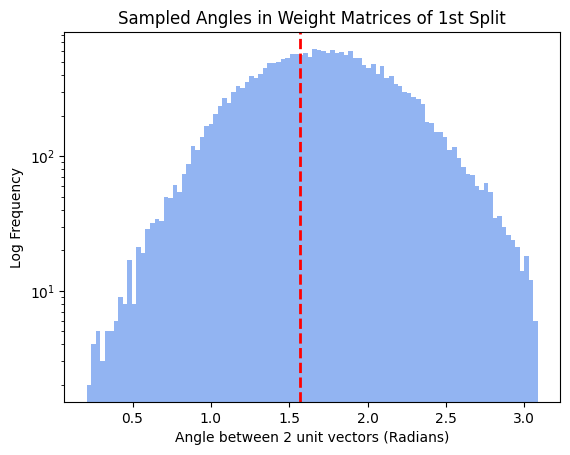

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming weights is the name of your dictionary
# Can't plot 80M points. Sample 100K from distribution. Should tend to true dist.
sampled_dist = torch.cat(list(sampled_angles.values())).numpy()

plt.hist(sampled_dist, bins=100, log=True, color="cornflowerblue", alpha=0.7)
plt.title("Sampled Angles in Weight Matrices of 1st Split")
plt.xlabel("Angle between 2 unit vectors (Radians)")
plt.ylabel("Log Frequency")

# Draw a horizontal line at y=π/2
plt.axvline(np.pi / 2, color="red", linestyle="dashed", linewidth=2, label="x=pi/2")

plt.show()